In [1]:
# data processing and Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing

import sklearn
from sklearn.model_selection import train_test_split
    
# Libraries and packages for NLP
import nltk
import gensim
from gensim.models import Word2Vec

# Visualization 
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['figure.figsize'] = (12, 10)
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
print('*** --> Modules are imported: ')    
print("Python version:", sys.version)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

print("sklearn version:", sklearn.__version__)
print("nltk version:", nltk.__version__)
print("gensim version:", gensim.__version__)
import glob


*** --> Modules are imported: 
Python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.21.5
pandas version: 1.4.2
sklearn version: 1.0.2
nltk version: 3.7
gensim version: 4.1.2


In [2]:
path_test_neg=r'C:\Users\raja4\Downloads\aclImdb_v1.tar\aclImdb\test\neg'
path_test_pos=r'C:\Users\raja4\Downloads\aclImdb_v1.tar\aclImdb\test\pos'
path_train_neg=r'C:\Users\raja4\Downloads\aclImdb_v1.tar\aclImdb\train\neg'
path_train_pos=r'C:\Users\raja4\Downloads\aclImdb_v1.tar\aclImdb\train\pos'
file_list_neg = glob.glob(path_train_neg + "/*.txt")
file_list_pos = glob.glob(path_train_pos + "/*.txt")
file_list_neg_test = glob.glob(path_test_neg + "/*.txt")
file_list_pos_test = glob.glob(path_test_pos + "/*.txt")
test_neg_reviews=[]
for i in range(0,len(file_list_neg_test)):
    data=pd.read_table(file_list_neg_test[i])
    test_neg_reviews.append(data.columns.tolist()[0])
test_pos_reviews=[]
for i in range(0,len(file_list_pos_test)):
    data=pd.read_table(file_list_pos_test[i])
    test_pos_reviews.append(data.columns.tolist()[0])
neg_reviews=[]
for i in range(0,len(file_list_neg)):
    data=pd.read_table(file_list_neg[i])
    neg_reviews.append(data.columns.tolist()[0])
pos_reviews=[]
for i in range(0,len(file_list_pos)):
    data=pd.read_table(file_list_pos[i])
    pos_reviews.append(data.columns.tolist()[0])

test_x=test_pos_reviews+pos_reviews+test_neg_reviews+neg_reviews
test_y=np.append(np.ones((len(test_pos_reviews+pos_reviews))), np.zeros((len(test_neg_reviews+neg_reviews))))
df = pd.DataFrame(list(zip(test_x, test_y)), columns =['review', 'sentiment'])


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing

# data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px


import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score


# Libraries and packages for text (pre-)processing 
import string
import re
import nltk 
# nltk.download('stopwords')

from gensim.models import Word2Vec

# For type hinting
from typing import List



class Tokenizer: 
    """ After cleaning and denoising steps, in this class the text is broken up into tokens.
    if clean: clean the text from all non-alphanumeric characters,
    if lower: convert the text into lowercase,
    If de_noise: remove HTML and URL components,
    if remove_stop_words: and remove stop-words,
    If keep_neagation: attach the negation tokens to the next token 
     and treat them as a single word before removing the stopwords
     
    Returns:
    List of tokens
    """
    # initialization method to create the default instance constructor for the class
    def __init__(self,
                 clean: bool = True,
                 lower: bool = True, 
                 de_noise: bool = True, 
                 remove_stop_words: bool = True,
                keep_negation: bool = True) -> List[str]:
      
        self.de_noise = de_noise
        self.remove_stop_words = remove_stop_words
        self.clean = clean
        self.lower = lower
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.keep_negation = keep_negation

    # other methods  
    def denoise(self, text: str) -> str:
        """
        Removing html and URL components
        """
        html_pattern = r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"
        url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"

        text = re.sub(html_pattern, " ", text)
        text = re.sub(url_pattern," ",text).strip()
        return text
       
    
    def remove_stopwords(self, tokenized_text: List[str]) -> List[str]:
        text = [word for word in tokenized_text if word not in self.stopwords]
        return text

    
    def keep_negation_sw(self, text: str) -> str:
        """
        A function to save negation words (n't, not, no) from removing as stopwords
        """
        # to replace "n't" with "not"
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        # to join not/no into the next word
        text = re.sub("not ", " NOT", text)
        text = re.sub("no ", " NO", text)
        return text
    
    
    def tokenize(self, text: str) -> List[str]:
        """
        A function to tokenize words of the text
        """
        non_alphanumeric_pattern =r"[^a-zA-Z0-9]"
        
        # to substitute multiple whitespace with single whitespace
        text = ' '.join(text.split())

        if self.de_noise:
            text = self.denoise(text)
        if self.lower:
            text = text.lower()
        if self.keep_negation:
            text = self.keep_negation_sw(text)
            
        if self.clean:
            # to remove non-alphanumeric characters
            text = re.sub(non_alphanumeric_pattern," ", text).strip()

        tokenized_text = text.split()

        if self.remove_stop_words:
            tokenized_text = self.remove_stopwords(tokenized_text)

        return tokenized_text

    
    
def evaluate_model (y_true: pd.Series, 
                              y_pred: pd.Series, 
                              report:bool = False,
                              plot: bool = False)-> float:
    """
    A function to calculate F1, Accuracy, Recall, and Precision Score
    If report: it prints classification_report 
    If plot: it prints Confusion Matrix Heatmap
    """
    if report:
        print(classification_report(y_true, 
                            y_pred,
                            digits=4))
    if plot:
        # figure
        fig, ax = plt.subplots(figsize=(4, 4))
        conf_matrix = pd.crosstab(y_true, 
                           y_pred, 
                           rownames=['Actual'], 
                           colnames=['Predicted'])
        sns.heatmap(conf_matrix, 
                    annot=True, fmt=".0f",
                    cmap='RdYlGn', # use orange/red colour map
                    cbar_kws={'fraction' : 0.04}, # shrink colour bar
                    linewidth=0.3, # space between cells
                   ) 
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        
    if not report and not plot:
        print('* Accuracy Score: ', "{:.4%}".format(accuracy_score(y_true, y_pred)))
        print('* F1 Score: ', "{:.4%}".format(f1_score(y_true, y_pred )))
        print('* Recall Score: ', "{:.4%}".format(recall_score(y_true , y_pred )))
        print('* Precision Score: ', "{:.4%}".format(precision_score(y_true , y_pred)))
        
    
    
    
    
def bow_vectorizer(doc_tokens: List[str]):
    """
    Using CountVectorizer, this function converts a list of tokenized text documents to a matrix of token counts (a Bog-of-Words sparse matrix).
    
    Parameters:
    doc_tokens               : A tokenized document 

    Returns:
    fit_bow_count_vect       : A fit Bog-of-Words model

    """
    # Defining CountVectorizer
    count_vect = CountVectorizer(
        analyzer='word',
        tokenizer=lambda doc:doc,
        preprocessor=lambda doc:doc,
        min_df=5,
        token_pattern=None)
    
    # Create a sparse matrix out of the frequency of vocabulary words in Train Dataset
    fit_bow_count_vect = count_vect.fit(doc_tokens)
    
    return fit_bow_count_vect
    
    

def train_logistic_regressor(train_data_bow_matrix, 
                             train_data_label: pd.Series):
    """
    This function builds a LogisticRegressionCV Classifier Model with Bag-of-Words matrix of the Train dataset.
    
    Parameters:
    train_data_bow_matrix    : A Train dataset as Bog-of-Words sparse matrix 
    train_data_label         : Target values of the Train dataset

    Returns:
    bow_logistreg_model      : A fit LogisticRegression model on Bag-of_words vectors
    """
    bow_logistreg_model=LogisticRegressionCV(cv=5,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=3,
                                             max_iter=300).fit(train_data_bow_matrix, train_data_label)
    
    train_data_predict_label = bow_logistreg_model.predict(train_data_bow_matrix)
    
    print("==> Evaluation metrics on training data: ")
    evaluate_model(y_true = train_data_label, 
                   y_pred = train_data_predict_label)
    return bow_logistreg_model


def w2v_trainer(doc_tokens: List[str],
                epochs: int = 10,
                workers: int = 3,
                vector_size: int = 300,
                window: int = 5,
                min_count: int = 2):
    """ 
    Going through a list of lists, where each list within the main list contains a set of tokens from a doc, this function trains a Word2Vec model,
    then creates two objects to store keyed vectors and keyed vocabs   
    Parameters:
    doc_tokens   : A tokenized document 
    epochs       : Number of epochs training over the corpus
    workers      : Number of processors (parallelization)
    vector_size  : Dimensionality of word embeddings
    window       : Context window for words during training
    min_count    : Ignore words that appear less than this

    Returns:
    keyed_vectors       : A word2vec vocabulary model
    keyed_vocab 
    
    """
    w2v_model = Word2Vec(doc_tokens,
                         epochs=10,
                         workers=3,
                         vector_size=300,
                         window=5,
                         min_count=2)
    
    # create objects to store keyed vectors and keyed vocabs
    keyed_vectors = w2v_model.wv
    keyed_vocab = keyed_vectors.key_to_index
    
    return keyed_vectors, keyed_vocab
    
    
    
def calculate_overall_similarity_score(keyed_vectors,
                             target_tokens: List[str], 
                             doc_tokens: List[str]) -> float:
    """
    Going through a tokenized doc, this function computes vector similarity between 
    doc_tokens and target_tokens as 2 lists by n_similarity(list1, list2) method based on 
    Word2Vec vocabulary (keyed_vectors), 
    then returns the similarity scores.  
    
    Parameters:
    target_tokens  : A set of semantically co-related words  
    doc_tokens     : A tokenized document 
    keyed_vectors  : A word2vec vocabulary model
    
    Returns:
    vector similarity scores between 2 tokenized list doc_tokens and target_tokens  
    """
    
    target_tokens = [token for token in target_tokens if token in keyed_vectors]

    doc_tokens = [token for token in doc_tokens if token in keyed_vectors]
    
    similarity_score = keyed_vectors.n_similarity(target_tokens, doc_tokens)
    
    return similarity_score


def overall_semantic_sentiment_analysis (keyed_vectors, 
                                         positive_target_tokens: List[str],
                                         negative_target_tokens: List[str],
                                         doc_tokens: List[str], 
                                         doc_is_series: bool = True) -> float:
    """
    This function calculates the semantic sentiment of the text. 
    It first computes a  vector for the text (average of the  wordvectors building the text document vector)
    and two vectors representing our given positive and negative lists of words 
    and then calculates Positive and Negative Sentiment Scores as cosine similarity 
    between the text vector and the positive and negative vectors respectively.
    
    Parameters:
    keyed_vectors           : A word2vec vocabulary model
    positive_target_tokens  : A list of sentiment or opinion words that indicate positive opinions 
    negative_target_tokens  : A list of sentiment or opinion words that indicate negative opinions  
    doc_tokens              : A tokenized document 
    
    
    Returns:
    positive_score : vector similarity scores between doc_tokens and positive_target_tokens
    negative_score : vector similarity scores between doc_tokens and negative_target_tokens
    
    semantic_sentiment_score  : positive_score - negative_score
    semantic_sentiment_polarity : Overall score: 0 for more negative or 1 for more positive doc
    """
  
    positive_score = doc_tokens.apply(lambda x: calculate_overall_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=positive_target_tokens, 
                                                                 doc_tokens=x))

    negative_score = doc_tokens.apply(lambda x: calculate_overall_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=negative_target_tokens, 
                                                                 doc_tokens=x))

    semantic_sentiment_score = positive_score - negative_score
    
    semantic_sentiment_polarity = semantic_sentiment_score.apply(lambda x: 1 if (x > 0) else 0)
                                          
    return positive_score, negative_score, semantic_sentiment_score, semantic_sentiment_polarity


def list_similarity(keyed_vectors, 
                    wordlist1: List[str], 
                    wordlist2: List[str]) -> pd.Series:
    """ A function to calculate vector similarity between 2 lists of tokens"""
    wv1= np.array([keyed_vectors[wd] for wd in wordlist1 if wd in keyed_vectors])
    wv2= np.array([keyed_vectors[wd] for wd in wordlist2 if wd in keyed_vectors])
    wv1 /= np.linalg.norm(wv1, axis=1)[:, np.newaxis]
    wv2 /= np.linalg.norm(wv2, axis=1)[:, np.newaxis]

    return np.dot(wv1, np.transpose(wv2))
    

def calculate_topn_similarity_score(keyed_vectors, 
                          target_tokens: List[str], 
                          doc_tokens: List[str],
                          topn: int = 10) -> float:
    """ The function defines the similarity of a single word to a document, 
    as the average of its similarity with the top_n most similar words in that document. 
    To calculate the similarity score it calculates the similarity of every word in the target_tokens set with all the words in the doc_tokens, 
    and keeps the top_n highest scores for each word and then averages over all the kept scores.
    -----
    Parameters:
    target_tokens List[str] : A list of sentiment or opinion words that indicate negative or positive opinions  
    
    doc_tokens List[str]    : A tokenized document 
    
    keyed_vectors           : A word2vec vocabulary model
    
    topn (int)              : An int that indicates the number of
    most similar vectors used to calculate the similarity score.

    
    Returns:
    vector similarity scores between 2 tokenized list doc_tokens and target_tokens  
    """
    topn = min(topn, round(len(doc_tokens)))
    
    target_tokens = [token for token in target_tokens if token in keyed_vectors]

    doc_tokens = [token for token in doc_tokens if token in keyed_vectors]
    
    sim_matrix = list_similarity(keyed_vectors=keyed_vectors, 
                                 wordlist1=target_tokens,
                                 wordlist2=doc_tokens)
    sim_matrix = np.sort(sim_matrix, axis=1)[:, -topn:]
     
    similarity_score = np.mean(sim_matrix)
    
    return similarity_score




def topn_semantic_sentiment_analysis(keyed_vectors, 
                                      positive_target_tokens: List[str],
                                      negative_target_tokens: List[str],
                                      doc_tokens: List[str],
                                      topn: int = 10) -> float:
    """
    A function to calculate the semantic sentiment of the text by measuring vector similarity between 
    doc_tokens and a positive_target_tokens (as positive_score) then measuring vector similarity between 
    doc_tokens and a negative_target_tokens (as negative_score), and finally comparing these two scores. 
    
    Parameters:
    keyed_vectors           : A word2vec vocabulary model
    positive_target_tokens  : A list of sentiment or opinion words that indicate positive opinions 
    negative_target_tokens  : A list of sentiment or opinion words that indicate negative opinions  
    doc_tokens              : A tokenized document 
    
    
    Returns:
    positive_score            : vector similarity scores between doc_tokens and positive_target_tokens
    negative_score            : vector similarity scores between doc_tokens and negative_target_tokens
    
    semantic_sentiment_score  : positive_score - negative_score
    semantic_sentiment_polarity       : Overall score: 0 for more negative or 1 for more positive doc
    """
  
    positive_score = doc_tokens.apply(lambda x: calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=positive_target_tokens, 
                                                                 doc_tokens=x,
                                                                     topn=topn))
                                      
    negative_score = doc_tokens.apply(lambda x: calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=negative_target_tokens, 
                                                                 doc_tokens=x,
                                                                     topn=topn))
                                           
    semantic_sentiment_score = positive_score - negative_score
    
    semantic_sentiment_polarity = semantic_sentiment_score.apply(lambda x: 1 if (x > 0) else 0)
                                          
    return positive_score, negative_score, semantic_sentiment_score, semantic_sentiment_polarity


def text_SSA(keyed_vectors,
              tokenizer,
              positive_target_tokens: List[str],
              negative_target_tokens: List[str],
              topn: int = 30) -> float:
    """
    A function to analyze text semantic sentiment.
    """
    repeat = True
    while repeat:
        txt = input("Please insert text here: \n")
        tokenized_txt = tokenizer.tokenize(txt)
        txt_PSS = calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                    target_tokens=positive_target_tokens, 
                                    doc_tokens=tokenized_txt,
                                    topn=topn)

        txt_NSS = calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                    target_tokens=negative_target_tokens, 
                                    doc_tokens=tokenized_txt,
                                    topn=topn)

        txt_S3 = txt_PSS - txt_NSS
        semantic_sentiment_polarity = "Positive" if (txt_S3 >= 0) else "Negative"
        green = "\033[1;32m"
        red = "\033[1;31m"
        color = green if (txt_S3 >= 0) else red # to print colored text

        print("Tokenized text:\n ", tokenizer.tokenize(txt))
        print("PSS =", txt_PSS)
        print("NSS =", txt_NSS)
        print("S3 =", txt_S3)
        print(color + "Semantic Sentiment =", semantic_sentiment_polarity)
        print("\n")
        repeat = False
        answer = input('Do you want to analyze another text sentiment? (Yes/No): ').upper()
        if answer in ['Y', 'YES', 'YEP', 'YA']:
            repeat = True
            print("-------------------------")

        else:
            print ('\n Thank you! See you later.')
    return

  
def define_complexity_subjectivity_reviews(df_slice,
                                          evaluate: bool = False,
                                          plot: bool = False):
  
      """
      A function to define high sentiment complexity reviews and Low Subjectivity reviews in a slice of dataset. 
      If evaluate: it evaluates the TopSSA model performance in df_slice 
      If plot: It plots distribution of low subjectivity reviews vs. high complexity reviews.
      """
      PSS_mean = df_slice["topn_PSS"].mean()
      PSS_std = df_slice["topn_PSS"].std()
      NSS_mean = df_slice["topn_NSS"].mean()
      NSS_std = df_slice["topn_NSS"].std()

      # High PSS(NSS)
      high_PSS = df_slice["topn_PSS"] > PSS_mean + PSS_std
      high_NSS = df_slice["topn_NSS"] > NSS_mean + NSS_std

      # Low PSS(NSS)
      low_PSS = df_slice["topn_PSS"] < PSS_mean - PSS_std
      low_NSS = df_slice["topn_NSS"] < NSS_mean - NSS_std

      # High sentiment complexity
      high_complexity = high_PSS & high_NSS
      df_slice_high_complexity = df_slice[high_complexity]

      # low subjectivity
      low_subjectivity = low_PSS & low_NSS
      df_slice_low_subjectivity = df_slice[low_subjectivity]

      if evaluate:
          print("\n Number of reviews with high sentiment complexity: ", len(df_slice_high_complexity))
          evaluate_model(df_slice_high_complexity["sentiment"],
                         df_slice_high_complexity["topn_semantic_sentiment_polarity"])


          print("\n Number of reviews with less subjectivity: ", len(df_slice_low_subjectivity))
          evaluate_model(df_slice_low_subjectivity["sentiment"], 
                         df_slice_low_subjectivity["topn_semantic_sentiment_polarity"])
          print("\n")

      if plot:
          # PLOTTING
          # filter positive and negative review based on Target Variable (actual 'y') or 'sentiment' column
          actual_pos_filt = df_slice_high_complexity['sentiment'] == 1
          actual_neg_filt = df_slice_high_complexity['sentiment'] == 0

          actual_pos_low_subjectivity = df_slice_low_subjectivity['sentiment'] == 1
          actual_neg_low_subjectivity = df_slice_low_subjectivity['sentiment'] == 0

          # plotting Semantic Sentiment Score Position of Actual Negative Reviews 
          plt.scatter(df_slice_low_subjectivity['topn_NSS'][actual_neg_low_subjectivity], 
                   df_slice_low_subjectivity['topn_PSS'][actual_neg_low_subjectivity],  
                   label='Actual Negetive Low Subjectivity Reviews',
                     color='deeppink',
                      alpha=0.4 , # set transparency of color
                      s=20 # set size of dots
                     )

          # plotting Semantic Sentiment Score Position of Actual Positive Reviews 
          plt.scatter(df_slice_low_subjectivity['topn_NSS'][actual_pos_low_subjectivity], 
                   df_slice_low_subjectivity['topn_PSS'][actual_pos_low_subjectivity],  
                   label='Actual Positive Low Subjectivity Reviews',
                 color='springgreen',
                      alpha=0.2, # set transparency of color
                      s=20 # set size of dots
                     )

          # plotting Semantic Sentiment Score Position of Actual Negative Reviews 
          plt.scatter(df_slice_high_complexity['topn_NSS'][actual_neg_filt], 
                   df_slice_high_complexity['topn_PSS'][actual_neg_filt],  
                   label='Actual Negetive High Complexity Reviews',
                     color='DarkRed',
                      alpha=0.4 , # set transparency of color
                      s=20 # set size of dots
                     )

          # plotting Semantic Sentiment Score Position of Actual Positive Reviews 
          plt.scatter(df_slice_high_complexity['topn_NSS'][actual_pos_filt], 
                   df_slice_high_complexity['topn_PSS'][actual_pos_filt],  
                   label='Actual Positive High Complexity Reviews',
                 color='DarkGreen',
                      alpha=0.5, # set transparency of color
                      s=20 # set size of dots
                     )
          # naming the x & y axis
          plt.xlabel('Predicted Negative Sentiment Score (NSS)')
          plt.ylabel('Predicted Positive Sentiment Score (PSS)')


          # plotting the bisector
          plt.plot([0,0.4], 
                   [0,0.4], 
                   alpha=0.5,
                   label='Decision Boundry')

          # show a legend on the plot
          plt.legend()

          # giving a title to the graph
          plt.title("""
          Distribution of low subjectivity reviews vs. high complexity reviews
          """)

          # To save the result in the same folder
          plt.savefig('../reports/figures/low_subjectivity_vs_high_complexity_reviews_on_PSS_NSS_plane.png')

          plt.show()

      return df_slice_high_complexity, df_slice_low_subjectivity

  
def explore_high_complexity_reviews(df_slice):  
      """
      A function to plot the distribution of high complexity reviews on the PSS-NSS plane.
      Using plotly, this plot let you explore the reviews by hovering over the datapoints.
      """
      df_slice_high_complexity1 =define_complexity_subjectivity_reviews(df_slice)[0]
      text_high_complexity = df_slice_high_complexity1['review'].str.wrap(100).str.replace("\n", "<br>"),

      fig = px.strip(df_slice_high_complexity1, 
                     x= "topn_NSS", 
                     y="topn_PSS",
                     color= "sentiment",
                     color_discrete_sequence=['red','green'],
                     hover_name = "tokenized_text_len",
                     hover_data=text_high_complexity,
                     height=800,
                     width=800)

      fig.update_layout(
         title = "Distribution of high complexity reviews on the PSS-NSS plane",
         xaxis_title = "Negative Sentiment Score (NSS)",
         yaxis_title = "Positive Sentiment Score (PSS)",
         font = dict(
            family = "Courier New, monospace",
            size = 12,
            color = "#7f7f7f"
         )
      )

      fig.add_trace(px.line(x=[0.2,0.4], y=[0.2,0.4]).data[0])

      fig.show()

      return
    
  
def explore_low_subjectivity_reviews(df_slice):
      """
      A function to plot the distribution of low subjectivity reviews on the PSS-NSS plane.
      Using plotly, this plot let you explore the reviews by hovering over the datapoints.
      """
      df_slice_low_subjectivity = define_complexity_subjectivity_reviews(df_slice)[1]
      text_low_subjectivity = df_slice_low_subjectivity['review'].str.wrap(100).str.replace("\n", "<br>"),


      fig = px.strip(df_slice_low_subjectivity, 
                     x= "topn_NSS", 
                     y="topn_PSS",
                     color= "sentiment",
                     color_discrete_sequence=['green','red'],
                     hover_name = "tokenized_text_len",
                     hover_data=text_low_subjectivity,
                     height=700,
                     width=700)

      fig.update_layout(
         title = "Distribution of low subjectivity reviews on the PSS-NSS plane",
         xaxis_title = "Negative Sentiment Score (NSS)",
         yaxis_title = "Positive Sentiment Score (PSS)",
         font = dict(
            family = "Courier New, monospace",
            size = 12,
            color = "#7f7f7f"
         )
      )

      fig.add_trace(px.line(x=[0,0.2], y=[0,0.2]).data[0])
      fig.show()

      return

In [4]:
tokenizer = Tokenizer(clean= True,
                      lower= True, 
                      de_noise= True, 
                      remove_stop_words= True,
                      keep_negation=True)

# Example statement
statement = "I didn't like this movie. It wasn't amusing nor visually interesting . I do not recommend it."
print(tokenizer.tokenize(statement))

['NOTlike', 'movie', 'NOTamusing', 'visually', 'interesting', 'NOTrecommend']


In [5]:
# Tokenize reviews
df['tokenized_text'] = df['review'].apply(tokenizer.tokenize)

df['tokenized_text_len'] = df['tokenized_text'].apply(len)
df['tokenized_text_len'].apply(np.log).describe()

count    50000.000000
mean         4.570297
std          0.652404
min          0.693147
25%          4.158883
50%          4.499810
75%          4.983607
max          7.270313
Name: tokenized_text_len, dtype: float64

In [6]:
y = df['sentiment'] 
X = df.drop(columns=['sentiment']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.3,
                                                    stratify=y)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (35000, 3)
X_test shape:  (15000, 3)


In [7]:
%%time
# Training a Word2Vec model
keyed_vectors, keyed_vocab = w2v_trainer(df['tokenized_text'],
                                               epochs=10,
                                               workers=3,
                                               vector_size=300,
                                               window=5,
                                               min_count=2)

CPU times: total: 4min 51s
Wall time: 1min 38s


In [8]:
keyed_vectors.most_similar('good',topn=15)

[('decent', 0.6528365612030029),
 ('NOTbad', 0.5432862043380737),
 ('great', 0.5422346591949463),
 ('passable', 0.5171021819114685),
 ('alright', 0.5147696733474731),
 ('bad', 0.5020797848701477),
 ('okay', 0.49109116196632385),
 ('acceptable', 0.48567208647727966),
 ('NOTgood', 0.48526713252067566),
 ('excellent', 0.4789282977581024),
 ('ok', 0.47783493995666504),
 ('nice', 0.4745781719684601),
 ('awesome', 0.4741933047771454),
 ('terrific', 0.469403475522995),
 ('fine', 0.4665013253688812)]

In [9]:
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]
len(positive_concepts)

10

In [10]:
keyed_vectors.most_similar('bad',topn=15)

[('terrible', 0.5910934805870056),
 ('horrible', 0.5821011662483215),
 ('awful', 0.5432259440422058),
 ('lousy', 0.51712965965271),
 ('good', 0.5020798444747925),
 ('NObad', 0.4986979365348816),
 ('sucks', 0.48868680000305176),
 ('atrocious', 0.4830883741378784),
 ('cheesy', 0.4600121080875397),
 ('crappy', 0.4494205117225647),
 ('dreadful', 0.4434671998023987),
 ('NOTgood', 0.4421372711658478),
 ('lame', 0.4380592405796051),
 ('horrid', 0.43745312094688416),
 ('NOTbad', 0.4367074966430664)]

In [11]:
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]
len(negative_concepts)

10

In [12]:
%%time
# Calculating Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'])

# Calculating Semantic Sentiment Scores by TopSSA model
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df['tokenized_text'],
                                                     topn=100)



# To store semantic sentiment store computed by OSSA model in df
df['overall_PSS'] = overall_df_scores[0] 
df['overall_NSS'] = overall_df_scores[1] 
df['overall_semantic_sentiment_score'] = overall_df_scores[2] 
df['overall_semantic_sentiment_polarity'] = overall_df_scores[3]



# To store semantic sentiment store computed by TopSSA model in df
df['topn_PSS'] = topn_df_scores[0] 
df['topn_NSS'] = topn_df_scores[1] 
df['topn_semantic_sentiment_score'] = topn_df_scores[2] 
df['topn_semantic_sentiment_polarity'] = topn_df_scores[3]

CPU times: total: 6min 46s
Wall time: 2min 39s


In [13]:
# TODO: Don't print the confusion matrix bc the report has 2 different F1 in it 
# OSSA Model Evaluation
print("OSSA Model Evaluation: ")
evaluate_model(df['sentiment'], 
               df['overall_semantic_sentiment_polarity'])

print("=======================")

# TopSSA Model Evaluation
print("TopSSA Model Evaluation: ")
evaluate_model(df['sentiment'], 
               df['topn_semantic_sentiment_polarity'])

OSSA Model Evaluation: 
* Accuracy Score:  77.2800%
* F1 Score:  77.2463%
* Recall Score:  77.1320%
* Precision Score:  77.3610%
TopSSA Model Evaluation: 
* Accuracy Score:  77.0280%
* F1 Score:  75.3646%
* Recall Score:  70.2760%
* Precision Score:  81.2477%


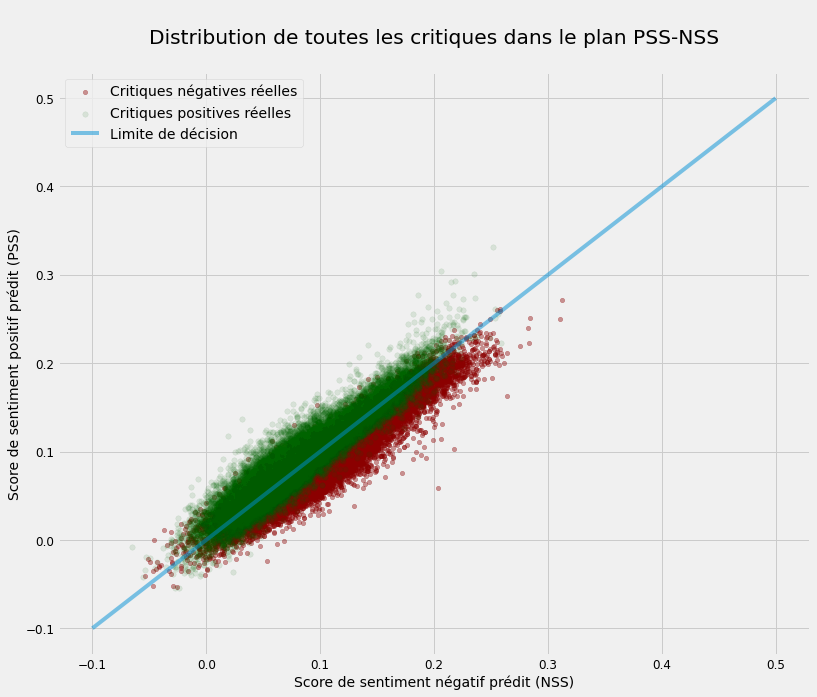

In [14]:
# TopSSA Model
# filter positive and negative review based on Target Variable (actual 'y') or 'sentiment' column
actual_pos_filt = df['sentiment'] == 1
actual_neg_filt =  df['sentiment'] == 0

# filter positive and negative review based on Most Probable predicted 'y' or 'topn_semantic_sentiment_score' column
predicted_pos_filt = df['topn_semantic_sentiment_polarity'] == 1
predicted_neg_filt = df['topn_semantic_sentiment_polarity'] == 0



# plotting Semantic Sentiment Score Position of Actual Negative Reviews 
plt.scatter(df['topn_NSS'][actual_neg_filt], 
         df['topn_PSS'][actual_neg_filt],  
         label='Critiques négatives réelles',
           color='DarkRed',
            alpha=0.4 , # set transparency of color
            s=20 # set size of dots
           )

# plotting Semantic Sentiment Score Position of Actual Positive Reviews 
plt.scatter(df['topn_NSS'][actual_pos_filt], 
         df['topn_PSS'][actual_pos_filt],  
         label='Critiques positives réelles',
       color='DarkGreen',
            alpha=0.1, # set transparency of color
            s=30 # set size of dots
           )
# naming the x & y axis
plt.xlabel('Score de sentiment négatif prédit (NSS)')
plt.ylabel('Score de sentiment positif prédit (PSS)')


# plotting the bisector
plt.plot([-0.1,0.5], 
         [-0.1,0.5], 
         alpha=0.5,
        label='Limite de décision')

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title("""
Distribution de toutes les critiques dans le plan PSS-NSS
""")

# To save the result in the same folder

plt.show()

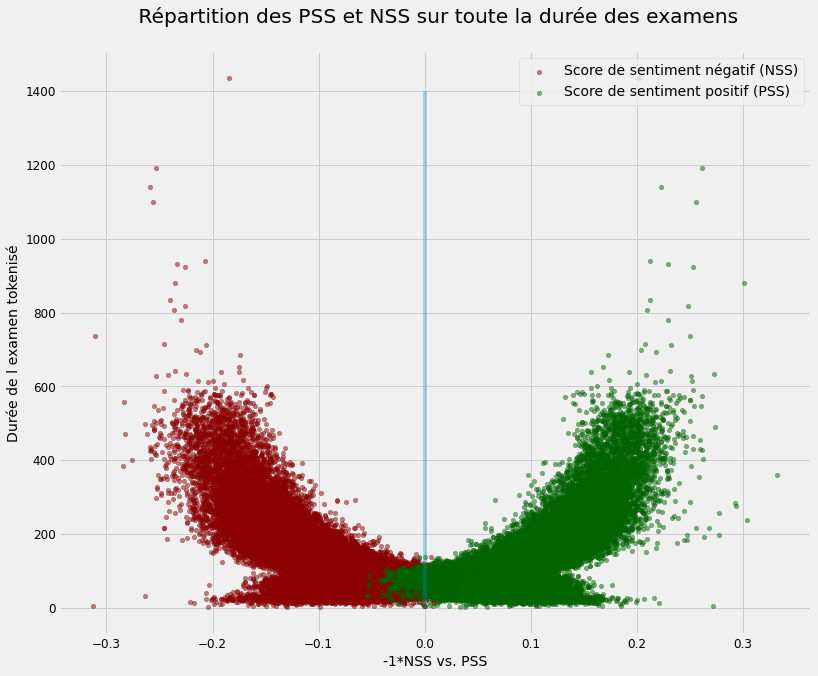

In [15]:
# To plot the relationship between length of review and its Semantic Sentiment Score
# to plot Negative Score Position of all Reviews
plt.scatter(-df['topn_NSS'], 
            df['tokenized_text_len'],
            label='Score de sentiment négatif (NSS)',
            color='DarkRed',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# to plot Positive Score Position of all Reviews
plt.scatter(df['topn_PSS'], 
            df['tokenized_text_len'],  
            label='Score de sentiment positif (PSS)',
            color='DarkGreen',
            alpha=0.5, # set transparency of color
            s=20 # set size of dots
           )

# naming the x & y axis
plt.xlabel('-1*NSS vs. PSS')
plt.ylabel('Durée de l examen tokenisé')

# plotting the bisector
plt.plot([0,0], [0,1400], alpha=0.3) 

# show a legend on the plot
plt.legend()

# giving a title to the graph
plt.title(""" Répartition des PSS et NSS sur toute la durée des examens
""")

# To save the result in the same folder


plt.show()

In [16]:
df_slice = df[df["tokenized_text_len"].between(100,140)]
len(df_slice)

8402

In [17]:
evaluate_model(df_slice["sentiment"] , 
                         df_slice["topn_semantic_sentiment_polarity"],
                        report=True)

              precision    recall  f1-score   support

         0.0     0.7296    0.8394    0.7806      4333
         1.0     0.7963    0.6687    0.7270      4069

    accuracy                         0.7567      8402
   macro avg     0.7630    0.7540    0.7538      8402
weighted avg     0.7619    0.7567    0.7546      8402




 Number of reviews with high sentiment complexity:  862
* Accuracy Score:  80.2784%
* F1 Score:  63.6752%
* Recall Score:  60.3239%
* Precision Score:  67.4208%

 Number of reviews with less subjectivity:  969
* Accuracy Score:  59.4427%
* F1 Score:  64.1096%
* Recall Score:  57.2594%
* Precision Score:  72.8216%




FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/low_subjectivity_vs_high_complexity_reviews_on_PSS_NSS_plane.png'

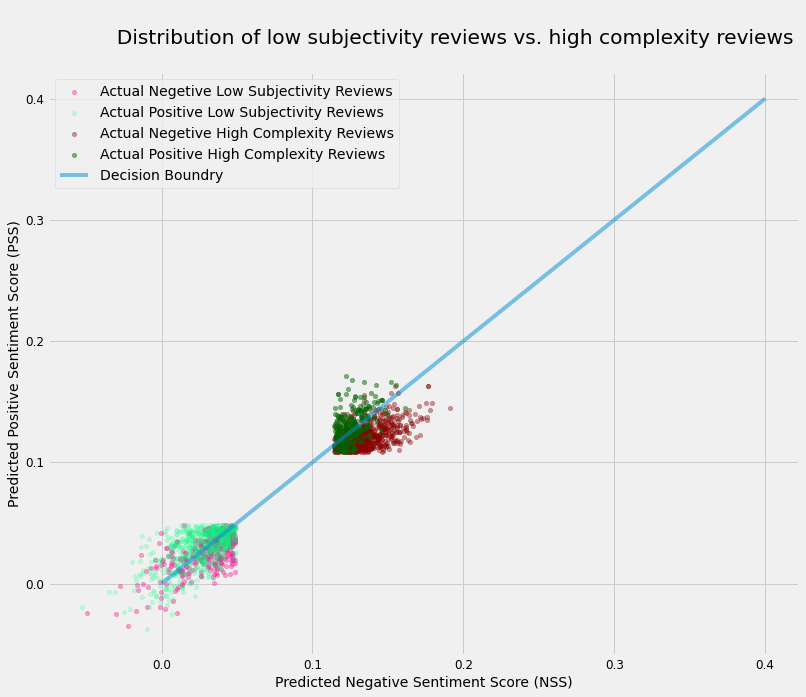

In [18]:
df_slice_high_complexity, df_slice_low_subjectivity = define_complexity_subjectivity_reviews(df_slice,
                                       evaluate=True,
                                       plot=True)